In [ ]:
pip install pandas pycaret sqlalchemy psycopg2 tabulate sklearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from pycaret.classification import *
from tabulate import tabulate
from sqlalchemy import create_engine
from config import DB_USERNAME, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
connection_string = f"postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

In [12]:
df_hr_data = pd.read_sql("SELECT * FROM tbl_hr_data", engine)
df_new_employees = pd.read_sql("SELECT * FROM tbl_new_employees", engine)

In [17]:
print("HR Data:")
print(tabulate(df_hr_data.head(), headers='keys', tablefmt='psql'))
print("\nNew Employees Data:")
print(tabulate(df_new_employees.head(), headers='keys', tablefmt='psql'))

HR Data:
+----+----------------------+-------------------+------------------+------------------------+----------------------+-----------------+--------------------+-------------------------+---------------+----------+---------------+
|    |   satisfaction_level |   last_evaluation |   number_project |   average_montly_hours |   time_spend_company |   Work_accident |   Quit_the_Company |   promotion_last_5years | Departments   | salary   | employee_id   |
|----+----------------------+-------------------+------------------+------------------------+----------------------+-----------------+--------------------+-------------------------+---------------+----------+---------------|
|  0 |                 0.38 |              0.53 |                2 |                    157 |                    3 |               0 |                  1 |                       0 | sales         | low      | EMP00001      |
|  1 |                 0.8  |              0.86 |                5 |                    262

In [18]:
df_hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15004 entries, 0 to 15003
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     15004 non-null  float64
 1   last_evaluation        15004 non-null  float64
 2   number_project         14999 non-null  float64
 3   average_montly_hours   15004 non-null  int64  
 4   time_spend_company     14999 non-null  float64
 5   Work_accident          15000 non-null  float64
 6   Quit_the_Company       15004 non-null  int64  
 7   promotion_last_5years  15004 non-null  int64  
 8   Departments            15004 non-null  object 
 9   salary                 15004 non-null  object 
 10  employee_id            15004 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 1.3+ MB


In [42]:
clf = setup(
    data=df_hr_data,
    target="Quit_the_Company",
    session_id=123,
    ignore_features=["employee_id"],
    categorical_features=["salary", "Departments"],
    train_size=0.8,
    fold_shuffle=True,
    verbose=True
)

,Description,Value
0,Session id,123
1,Target,Quit_the_Company
2,Target type,Binary
3,Original data shape,"(15004, 11)"
4,Transformed data shape,"(15004, 21)"
5,Transformed train set shape,"(12003, 21)"
6,Transformed test set shape,"(3001, 21)"
7,Ignore features,1
8,Numeric features,7
9,Categorical features,2


In [43]:
clf.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9893,0.9915,0.9633,0.9914,0.9771,0.9701,0.9703,0.4460
et,Extra Trees Classifier,0.9856,0.9912,0.9553,0.9839,0.9693,0.9599,0.9601,0.4040
lightgbm,Light Gradient Boosting Machine,0.9853,0.9935,0.9504,0.9877,0.9686,0.9590,0.9594,0.3250
dt,Decision Tree Classifier,0.9773,0.9731,0.9650,0.9416,0.9531,0.9382,0.9383,0.0750
gbc,Gradient Boosting Classifier,0.9758,0.9882,0.9287,0.9688,0.9482,0.9325,0.9329,0.5380
ada,Ada Boost Classifier,0.9588,0.9824,0.9112,0.9157,0.9134,0.8863,0.8864,0.2800
knn,K Neighbors Classifier,0.9353,0.9704,0.9196,0.8283,0.8714,0.8284,0.8305,0.1850
qda,Quadratic Discriminant Analysis,0.8695,0.9249,0.8273,0.6932,0.7525,0.6652,0.6716,0.0860
lr,Logistic Regression,0.7945,0.8211,0.3666,0.6176,0.4592,0.3425,0.3608,1.4390
lda,Linear Discriminant Analysis,0.7846,0.8172,0.3453,0.5827,0.4327,0.3106,0.3272,0.0690


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [44]:
rf_model = clf.create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9892,0.9939,0.9615,0.9928,0.9769,0.9698,0.9701
1,0.9883,0.9944,0.9545,0.9964,0.9750,0.9674,0.9678
2,0.9908,0.9922,0.9756,0.9859,0.9807,0.9747,0.9748
3,0.9900,0.9932,0.9685,0.9893,0.9788,0.9723,0.9724
4,0.9942,0.9931,0.9825,0.9929,0.9877,0.9839,0.9839
5,0.9858,0.9837,0.9545,0.9856,0.9698,0.9606,0.9608
6,0.9842,0.9857,0.9406,0.9926,0.9659,0.9556,0.9562
7,0.9925,0.9924,0.9685,1.0000,0.9840,0.9791,0.9793
8,0.9900,0.9942,0.9685,0.9893,0.9788,0.9723,0.9724


In [49]:
predict_model(rf_model, data=get_config("X_train"))

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Departments,salary,prediction_label,prediction_score
8062,0.24,0.91,5.0,258,6.0,0.0,0,support,low,0,0.91
2426,0.65,0.40,2.0,141,2.0,0.0,0,IT,low,0,0.99
1138,0.09,0.92,6.0,303,5.0,0.0,0,sales,low,1,1.00
8683,0.23,0.96,4.0,213,4.0,0.0,0,technical,medium,0,0.97
8652,0.81,0.72,3.0,232,3.0,1.0,0,sales,medium,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
5407,0.49,0.74,3.0,229,3.0,1.0,0,IT,low,0,1.00
12001,0.80,0.86,5.0,262,6.0,0.0,0,sales,medium,1,0.99
13725,0.39,0.52,2.0,102,8.0,0.0,0,technical,medium,0,0.95
1543,0.77,0.81,5.0,237,5.0,0.0,0,sales,medium,1,0.77


In [63]:
holdout_preds = predict_model(rf_model, data=get_config("X_test"))
from sklearn.metrics import classification_report, accuracy_score

y_true = get_config("y_test")
y_pred = holdout_preds["prediction_label"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 0.9920026657780739
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.97      0.98       715

    accuracy                           0.99      3001
   macro avg       0.99      0.99      0.99      3001
weighted avg       0.99      0.99      0.99      3001



In [64]:
new_employees_data_with_predictions = predict_model(rf_model, data=df_new_employees)
print(tabulate(new_employees_data_with_predictions, headers='keys', tablefmt='psql'))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9200,0,0.0000,0.0000,0.0000,0.0000,0.0000


+----+----------------------+-------------------+------------------+------------------------+----------------------+-----------------+-------------------------+---------------+----------+---------------+--------------------+--------------------+--------------------+
|    |   satisfaction_level |   last_evaluation |   number_project |   average_montly_hours |   time_spend_company |   Work_accident |   promotion_last_5years | Departments   | salary   | employee_id   |   Quit_the_Company |   prediction_label |   prediction_score |
|----+----------------------+-------------------+------------------+------------------------+----------------------+-----------------+-------------------------+---------------+----------+---------------+--------------------+--------------------+--------------------|
|  0 |            0.880567  |        0.213571   |                2 |                    274 |                    3 |               0 |                       0 | technical     | low      | NE15005    

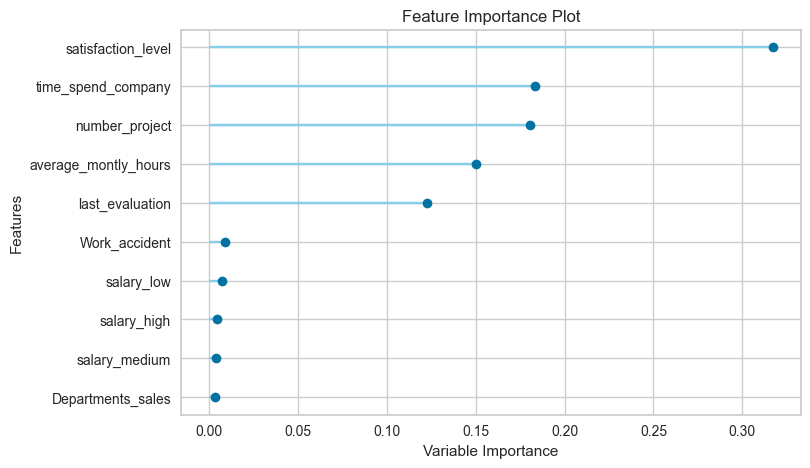

In [54]:
plot_model(rf_model , plot='feature')

In [57]:
# i want to make table feature with it's importance
feature_names = rf_model.feature_names_in_
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(tabulate(feature_importance_df, headers='keys', tablefmt='psql'))

+----+-------------------------+--------------+
|    | Feature                 |   Importance |
|----+-------------------------+--------------|
|  0 | satisfaction_level      |   0.317099   |
|  4 | time_spend_company      |   0.183612   |
|  2 | number_project          |   0.180275   |
|  3 | average_montly_hours    |   0.149923   |
|  1 | last_evaluation         |   0.122609   |
|  5 | Work_accident           |   0.0091664  |
| 17 | salary_low              |   0.00700434 |
| 19 | salary_high             |   0.00443864 |
| 18 | salary_medium           |   0.00377582 |
|  9 | Departments_sales       |   0.00345953 |
| 10 | Departments_technical   |   0.00332375 |
|  7 | Departments_support     |   0.0026797  |
|  6 | promotion_last_5years   |   0.00200418 |
| 15 | Departments_hr          |   0.00185328 |
| 11 | Departments_management  |   0.00171198 |
| 14 | Departments_accounting  |   0.00166217 |
|  8 | Departments_IT          |   0.00161477 |
| 16 | Departments_RandD       |   0.001

In [58]:
# write features importance to a new table in the database
feature_importance_df.to_sql('tbl_feature_importance', engine, if_exists='replace', index=False)

20

In [51]:
# write the predictions to a new table in the database
new_employees_data_with_predictions.to_sql('tbl_new_employees_with_predictions', engine, if_exists='replace', index=False)

100

In [52]:
# Save the model
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

In [62]:
from sqlalchemy import inspect

with pd.ExcelWriter('database_tables.xlsx') as writer:
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
    for table_name in table_names:
        df = pd.read_sql(f"SELECT * FROM {table_name}", engine)
        df.to_excel(writer, sheet_name=table_name, index=False)